# Inleiding
Als eers hebben wij het csv naar een exel bestand omgezet en de data bekeken. Wij ontdekten de volgende punten.

Wij er achter gekomen dat het moeilijk is om een wijn te identificeren. Zo kan een wijn uit hetzelfde jaar met dezelfde naam gereviewed door dezelfde persoon uit de zelfde streek andere chemische eigenschappen hebben. Dit roept vragen op. Namelijk zijn de wijnen hetzelfde en zo ja. Klopt de meting van de chemische eigenschappen dan wel. Wij hebben besloten er van uit te gaan dat wij de chemische eigenschappen kunnen vertrouwen. Dit omdat wij anders dusdanig beperkt zijn dat wij geen interessante correlaties kunnen maken en de opdracht dus niet voldaan kan worden. Wij weten dus niet in hoeverre de namen correct zijn. Dit kan voor problemen zorgen bij ML. 
Jaartal is niet specifiek aangegeven maar kan wel zeer bruikbaar zijn. Naar verkenning zijn wij er achter gekomen dat een titel wel vaak een jaar aangeeft. Wij hebben toen code geschreven om te kijken welke titels geen jaar bevat dit bleken er 4 te zijn.
Na verkenning zijn wij er achter gekomen dat provincies niet altijd bestaande provincies zijn maar dat er ook regio’s en onbruikbare waardes tussen zitten. Dit zorgt er dus voor dat wij niet soepel weerdata voor die regio kunnen opvragen en maakt een correlatie zoeken tussen weer in een regio en de  qualiteit van de wijn erg moeilijk Daarom kiezen wij ervoor om data van de hoofdstad te gebruiken i.p.v. data van verschillende plaatsen. De data van de hoofdstad (Lissabon) hebben we gevonden op www7.ncdc.noaa.gov/ dit is National Climatic Data Center van de United states department of commerce. Hier hebben wij de data van Lissabon van 1990 tot 2018 kunnen vinden.

## Onderzoek vragen

1. In hoeverre is de score van een Portugese Red te voorspellen op basis van de chemische kenmerken?
2. Welk effect heeft weer over de jaren heen effect op de wijn score die reviewers geven in punten?
3. Kan je op basis van score en prijs welke regio de wijn zijn oorsprong.


In [2]:
# Importeer nodige libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as itertools
import itertools

from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

# Dataset rode wijnen

We kiezen ervoor om de colommen country, variety en id te verwijderen, omdat Country alleen de value Portugal heeft evenals variety alleen de value Portuguese Red heeft. ID halen we weg, omdat deze niet handig is voor ons. We hoeven geen exact kolom aan te spreken. Het kan namelijk zijn dat 1 wijn meerdere beoordeelaars heeft of een beoordeelaar meerdere wijnen. Kort gezegd aan ID hebben we niks voor onze onderzoeksvragen.

Daarnaast verwijderen we alle kolommen met NAN waardes erin.

In [3]:
# lees het bestand in
redwines = pd.read_csv("redwine.csv", delimiter=";", encoding='iso-8859-1')

# Verwijder onnodige kolommen
redwines.drop(['country','variety','id'],axis=1, inplace=True)
redwines.dropna(inplace=True)

# Voeg jaartal toe als aparte kolom, en verwijder nan rijen voor jaren (2465 naar 2461)
redwines['year'] = redwines['title'].str.extract(r"([1][9][9]\d|[2][0][0,1,2]\d)")
redwines = redwines[redwines['year'].notnull()]
redwines['year'] = redwines['year'].astype(int)
redwines['count'] = 1

# lees tabel statistieken uit
redwines.describe()

,points,price,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,year,count
count,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.0
mean,88.860194,24.703398,8.349272,0.529723,2.574587,0.087831,16.008252,47.775243,3.310869,0.662427,2011.600485,1.0
std,2.947800,25.716501,1.742572,0.180143,1.419112,0.047329,10.423659,33.478012,0.155111,0.173984,2.812603,0.0
min,81.000000,5.000000,4.600000,0.120000,0.900000,0.012000,1.000000,6.000000,2.740000,0.330000,1996.000000,1.0
25%,87.000000,12.000000,7.100000,0.400000,1.900000,0.070000,8.000000,23.000000,3.210000,0.550000,2010.000000,1.0
50%,88.000000,17.000000,7.900000,0.520000,2.200000,0.079000,14.000000,38.000000,3.305000,0.620000,2012.000000,1.0
75%,91.000000,28.000000,9.300000,0.635000,2.600000,0.090250,21.000000,65.000000,3.400000,0.730000,2014.000000,1.0
max,100.000000,450.000000,15.900000,1.580000,15.500000,0.610000,72.000000,289.000000,4.010000,2.000000,2016.000000,1.0


# Data visualisatie

__Correlatie__

Als eerst is correlatie tabel gemaakt om inzicht te krijken in hoe hoog de correlatie tussen verschillende waarden zit. Dit gaf een iets treurig inzicht. De correlatie waarden zijn erg laag en er lijkt op het eerste ogenblik geen correlatie te zitten tussen de meesten van deze waarden. Zeker de weerwaarden lijken zeer weinig effect te hebben op de rest. De weerwaarden onderling hebben op logische wijs wel een hoge correlatie waarden. 

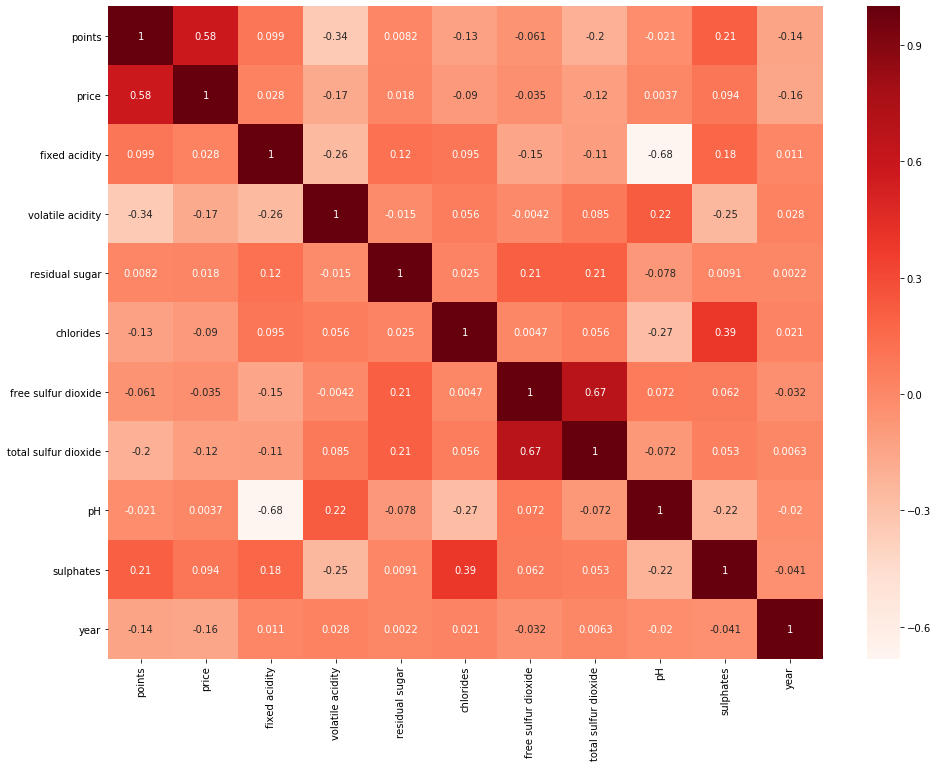

In [4]:
# Correlatie tabel voor dataset redwines
plt.figure(figsize=(16,12))
correlation_matrix = redwines.drop(['description','title','count'],axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

__Puntenverdeling__

Het is belangrijk om inzicht te hebben in hoe de punten zijn verdeeld. Na een korte analyse kwamen we erachter dat alle punten zijn verdeeld tussen 80 en 100. Daarmee is een wijn van 80 punten opeens de slechtst beoordeelde wijn terwijl het lijkt alsof dit een redelijk hoge score is. In onderstaande bar plot is te zien hoe de punten zijn verdeeld. 

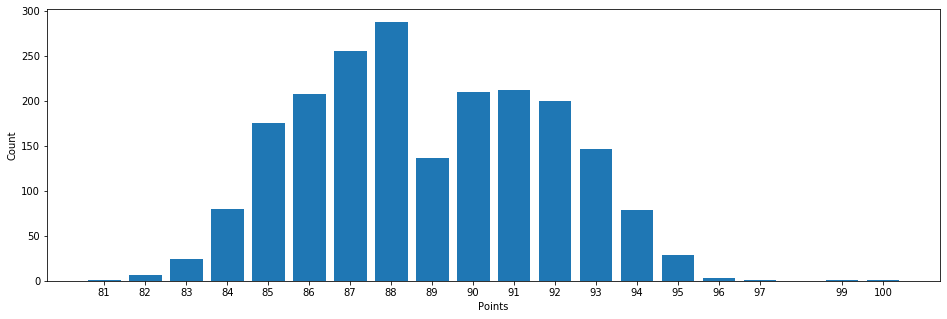

In [5]:
# Punt verdeling
points = redwines.groupby('points').sum()
plt.figure(figsize=(16,5))
plt.xticks(points.index)
plt.bar(points.index, points['count'])
plt.xlabel('Points')
plt.ylabel('Count')
plt.show()

__Boxplots__

Wij hebben ook besloten om een paar box plotten te maken van specifieke waarden om zo te zien hoe die zijn verdeeld.
Hier uit is te op te merken dat de pH relatief dicht bij elkaar ligt en dat er niet veel waarden zijn die er veel afwijken.

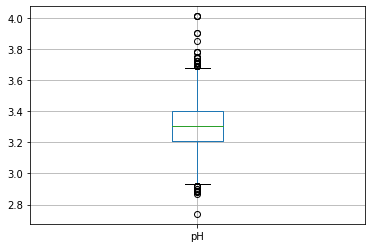

In [6]:
boxplot = redwines.boxplot('pH')

Hier uit is te zien dat het suiker gehalte veel waardes zijn die ver afwijken. Intresant genoeg zijn al deze waarden hoger dan de mediaan en zijn er weinig waarden lager

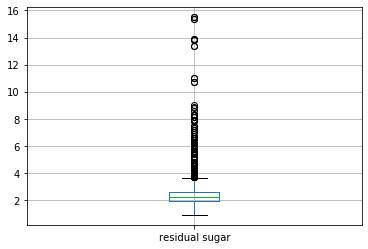

In [7]:
boxplot = redwines.boxplot('residual sugar')

__Gemiddelde prijs per score__

We vroegen ons als groepje ook af wat de correlatie is tussen wijn prijs en gegeven punten. Je zou zeggen dat de duurdere wijnen ook beter beoordeeld moeten zijn. Het aantal punten zou dus moeten oplopen naarmate de prijs hoger wordt. Dit bleek ook enigzins het geval zoals in de onderstaande scatter plot te zien is. Het is soms ook lastig te zeggen aangezien het onderlinge verschil tussen gegeven punten niet erg hoog is. Er is per puntenaantal een gemiddeld van de prijs genomen, en dit gemiddelde wordt getoond per puntenaantal.

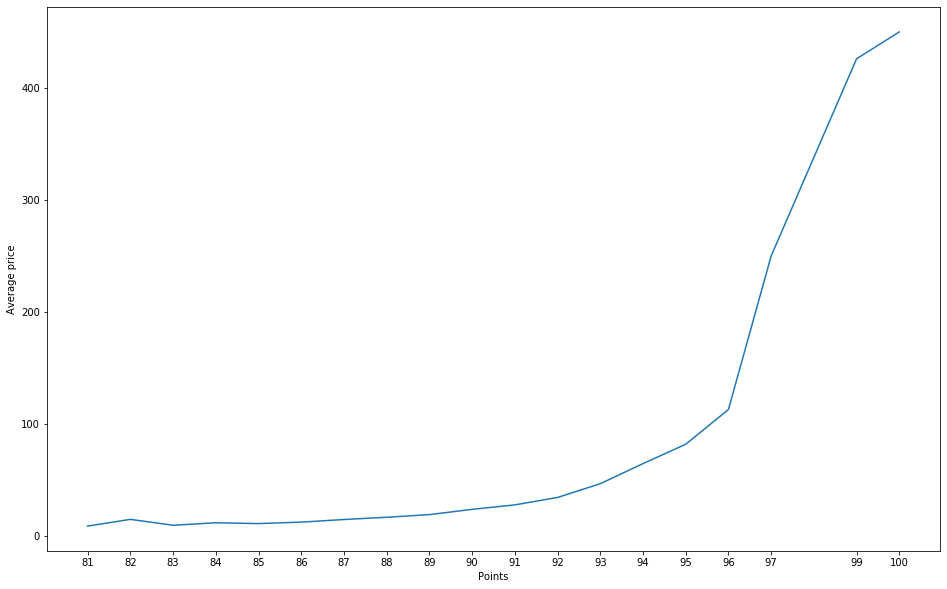

In [8]:
# Points in vergelijking met gemiddelde prijs 
avg = redwines.groupby('points').sum()
avg['avg_price_per_point'] = avg['price'] / avg['count']
plt.figure(figsize=(16,10))
plt.xticks(avg.index)
plt.plot(avg.index, avg['avg_price_per_point'])
plt.xlabel('Points')
plt.ylabel('Average price')
plt.show()

C:\Users\Freek\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Freek\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0, flags=flags)


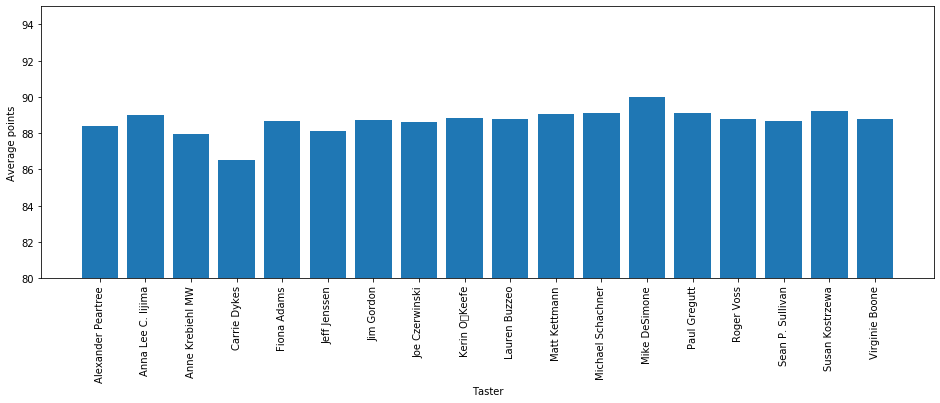

In [9]:
# Gemiddelde score per wijnproever
avg = redwines.groupby('taster_name').sum()
avg['avg_taster_given_points'] = avg['points'] / avg['count']
plt.figure(figsize=(16,5))
axes = plt.gca()
axes.set_ylim([80,95])
plt.bar(avg.index, avg['avg_taster_given_points'])
plt.ylabel('Average points')
plt.xlabel('Taster')
plt.xticks(avg.index, rotation='vertical')
plt.show()

__Suikergehalte over de jaren heen__

Zoals in onderstaande grafiek te zien is, heeft de suikergehalte over de jaren toegenomen met af en toe een uitschieter.

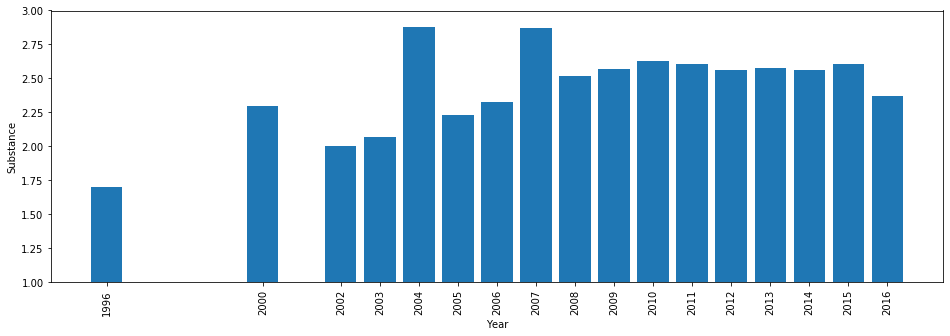

In [10]:
# verhoging van suikergehalte over de jaren
avg = redwines.groupby('year').sum()
avg['avg_increase_substance'] = avg['residual sugar'] / avg['count']
plt.figure(figsize=(16,5))
axes = plt.gca()
axes.set_ylim([1.0,3.0])
plt.bar(avg.index, avg['avg_increase_substance'])
plt.xticks(avg.index, rotation='vertical')
plt.ylabel('Substance')
plt.xlabel('Year')
plt.show()

## Onderzoek vraag 1
#### Correlatie tussen chemische eigenschappen en score

Wij willen graag weten of de score van een Portugese red te vorspellen is gegeven de chemische eigenschappen. Mocht dit namelijk zo zijn dan kunnen wij misschien ook in een later stadium achterhalen welke chemische eigenschappen en in welke hoeveelheid zorgen voor een hogere score. Dit is zeer belangrijke informatie die alle wijnbrouwerijen graag willen hebben.

Allereest zullen wij kijken of de .corr functie die inzicht probeert te geven in de correlatie tussen eigenschappen.
Een correlatie kan vinden tussen de score en een andere eigenschap van de wijn


In [11]:
redwines.corr()['points']

points                  1.000000
price                   0.579681
fixed acidity           0.098916
volatile acidity       -0.341979
residual sugar          0.008177
chlorides              -0.128953
free sulfur dioxide    -0.060824
total sulfur dioxide   -0.202779
pH                     -0.021254
sulphates               0.209667
year                   -0.139069
count                        NaN
Name: points, dtype: float64

Dit geeft geen goed vooruitzicht. Volgens de functie schijn er zeer weinig correlatie te zijn tussen de chemische eigenschappen en de score. Een conclusie dat er geen correlatie is lijk tot dusver het meest logisch.

Wij zullen dit veder uitzoeken met behulp van algoritme. 

Allereerst maken wij een baseline. Een baseline is de simpelste oplossing voor een probleem en kijken welk resultaat die oplevert. Dit is handig omdat je zo kan zien hoe goed je algoritme daadwerkelijk scoort. ZO kan je intuïtief denken dat 80% accuracy een goede score is maar kan je bijvoorbeeld met willekeurig een getal kiezen op een accuracy van 78% uitkomen. Dan heeft je algoritme dus niet veel toegevoegde waarden. 

Voor onze baseline is gekozen om een continue de scoren 88 te voorspellen. Dit is namelijk het meest voorkomende getal(de modus).

In [12]:
modus_pred = pd.Series(88, index=[redwines.index])
accuracy_score(redwines['points'], modus_pred)

0.13980582524271845

De baseline heeft een score van circa 14%. Nu zullen wij een lineaire regressie model proberen te bouwen.

Allereerste moeten we zorgen dat lineaire regressie kan worden uitgevoerd op de data set. Hiervoor moeten we dus alle strings wegehalen) en vervangen door andere waarden.

In [13]:
redwines.dtypes

description              object
designation              object
points                    int64
price                   float64
province                 object
taster_name              object
title                    object
winery                   object
fixed acidity           float64
volatile acidity        float64
citric acid              object
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                  object
pH                      float64
sulphates               float64
alcohol                  object
year                      int32
count                     int64
dtype: object

In de bovenstaande tabel is te zien dat de kolom 'density', 'citric acid' en 'alcohol' niet de juiste datatypen hebben. We willen hier floats hebben terwijl ze nu aangegeven worden als Strings. Om dit op te lossen gaan we over de kolommen heen en zetten iedere String om tot een float. Wanneer dit niet kan omdat de waarde dit niet toelaat wordt er een NaN ingevuld.

In [14]:
redwines['citric acid'] = pd.to_numeric(redwines['citric acid'], errors='coerce')
redwines['density'] = pd.to_numeric(redwines['density'], errors='coerce')
redwines['alcohol'] = pd.to_numeric(redwines['alcohol'], errors='coerce')

pd.isnull(redwines).sum()

description               0
designation               0
points                    0
price                     0
province                  0
taster_name               0
title                     0
winery                    0
fixed acidity             0
volatile acidity          0
citric acid             172
residual sugar            0
chlorides                 0
free sulfur dioxide       0
total sulfur dioxide      0
density                   1
pH                        0
sulphates                 0
alcohol                  10
year                      0
count                     0
dtype: int64

Hieruit blijk dat er circa 180 waarden zijn die niet naar een float kunnen worden omgezet. Wij hebben besloten om deze waarden uit onze data te halen. Ze kunnen ook geïnterpoleerd worden  maar aangezien wij de correlatie tussen deze waarden en de scoren willen vergelijken moet onze data wel exact zijn en wij kunnen niet garanderen dat als er een correlatie zit die ook mee wordt genomen in het interpoleren.

In [15]:
redwines_strings_dropped = redwines.copy()
redwines_strings_dropped.dropna(inplace=True)

In [16]:
# Creeër het lineare regressie object vanuit de module sklearn
red_wine_linreg_model = LinearRegression()

# Selecteren van kenmerken en doel
X = redwines_strings_dropped.loc[:,'fixed acidity':]
y = redwines_strings_dropped['points']

# Verdelen van data in train en testdata
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

print("Aantal waarden in de training set: {0}".format(len(X_train)))
print("Aantal waardes in de test set: {0}".format(len(X_test)))

# Start leerproces
red_wine_linreg_model.fit(X_train, y_train)

Aantal waarden in de training set: 1407
Aantal waardes in de test set: 470


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Na het maken van het model, willen we graag weten welke coëfficiënt het model heeft gekregen. Hieruit is namelijk op te maken hoe hoog het model de correlatie tussen bepaalde waarden inschat.

In [17]:
pd.DataFrame({'features': X.columns, 'coefficients': red_wine_linreg_model.coef_})

,features,coefficients
0,fixed acidity,-0.077335
1,volatile acidity,-3.102398
2,citric acid,-0.023480
3,residual sugar,-0.023401
4,chlorides,-5.682664
5,free sulfur dioxide,0.005279
6,total sulfur dioxide,-0.010270
7,density,0.009271
8,pH,-1.765934
9,sulphates,1.944891


We zien we dat chorides veel invloed heeft. Ook hebben volatile acicity, sulphates en alcohol invloed op de lijn.
Om te bepalen hoe of de voorspellende waarde overeenkomen met de werkelekheid. Laen we het algoritme voorspellingen laten met behulp van de test set.

In [18]:
def make_line_model(target,features_list):
    linregr_model = LinearRegression()
    X = redwines_strings_dropped[features_list]
    y = redwines_strings_dropped[target]

    # Creeëren van een train en test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    # Start leerproces
    linregr_model.fit(X_train, y_train)

    # Maken van voorspellingen met de testset
    wine_regr_test_orig = linregr_model.predict(X_test)
    wine_regr_test_rounded = np.rint(np.floor(linregr_model.predict(X_test)))

    # Uitrekenen van de gemiddelde afwijking en uitrekenen van de root mean squared error
    avg_dev = abs(wine_regr_test_orig - y_test).sum() / len(y_test)
    print("LinearRegression model with the features: {0}".format(features_list) )
    print("Algemene score (met afronding): {0}".format(accuracy_score(wine_regr_test_rounded, y_test)))
    print("\nGemiddelde afwijking: {0}".format(avg_dev))
    print("\n")

make_line_model('points',["fixed acidity","volatile acidity","citric acid","residual sugar",
            "chlorides","free sulfur dioxide","total sulfur dioxide","pH","sulphates","alcohol"])
make_line_model('points',["chlorides","pH","sulphates","alcohol"])
make_line_model('points',["chlorides"])
make_line_model('points',["pH"])
make_line_model('points',["sulphates"])
make_line_model('points',["alcohol"])

LinearRegression model with the features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol']
Algemene score (met afronding): 0.19148936170212766

Gemiddelde afwijking: 1.9807677905633658


LinearRegression model with the features: ['chlorides', 'pH', 'sulphates', 'alcohol']
Algemene score (met afronding): 0.1723404255319149

Gemiddelde afwijking: 2.06749176715754


LinearRegression model with the features: ['chlorides']
Algemene score (met afronding): 0.125531914893617

Gemiddelde afwijking: 2.5440964606180967


LinearRegression model with the features: ['pH']
Algemene score (met afronding): 0.1127659574468085

Gemiddelde afwijking: 2.582427252201153


LinearRegression model with the features: ['sulphates']
Algemene score (met afronding): 0.1276595744680851

Gemiddelde afwijking: 2.4909813523516107


LinearRegression model with the features: ['alcohol']
Algemene score (met afro

De resultaten zijn dusdanig laag dat er geen correlatie is te vinden tussen de eigenschappen en de score. Een verklaring hiervoor is dat er wel een correlatie is maar dat het algoritme moeite heeft een precieze score te berekenen. Zo kan bijvoorbeeld meer sulfide wel gelijk staan aan een hogere score maar voorspelt het algoritme 90 in plaats van 91 dus word het als fout gerekend. Een oplossing hiervoor is om de punten in groepen te verdelen wij hebben in eerste instantie gekozen om ze in groepen van 2 op te delen.




In [19]:
def organize_prize_groups(group_size):
    # Wanneer je de laagste waaarde van de huidige waarde haalt heb je het verschil. 
    # Daarbij zie je dat alle groepen consistent stijgen.
    # Je kan het nummber verdelen door de toename om een groep te krijgen.
    # Voeg 1 toe om de groep te laten starten bij 1 en niet 0
    
    redwines_strings_dropped["Points group"] = round((redwines_strings_dropped["points"] - 81) / group_size + 1)


In [20]:
organize_prize_groups(2)
redwines_strings_dropped

,description,designation,points,price,province,taster_name,title,winery,fixed acidity,volatile acidity,...,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,year,count,Points group
0,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Kerin OKeefe,Quinta dos Avidagos 2011 Avidagos Red (Douro),Quinta dos Avidagos,10.0,0.290,...,0.098,10.0,26.0,10.00600,3.48,0.91,9.7,2011,1,4.0
1,"From an estate in the south of the Alentejo, t...",Grande Reserva Tinto,91,26.0,Alentejano,Roger Voss,Casa Santa Vitória 2013 Grande Reserva Tinto R...,Casa Santa Vitória,8.3,0.260,...,0.076,8.0,23.0,0.99740,3.26,0.70,9.6,2013,1,6.0
2,A year in wood and 30 months in bottle before ...,Montes Claros Garrafeira,90,28.0,Alentejo,Paul Gregutt,Adega Cooperativa de Borba 2012 Montes Claros ...,Adega Cooperativa de Borba,7.0,0.690,...,0.091,15.0,21.0,0.99572,3.38,0.60,11.3,2012,1,6.0
4,"A powerful wine, richly structured and full of...",Gerações Colheita Seleccionada,92,34.0,Alentejano,Paul Gregutt,Herdade Grande 2010 Gerações Colheita Seleccio...,Herdade Grande,8.0,0.480,...,0.073,16.0,25.0,0.99360,3.28,0.66,12.4,2010,1,6.0
5,This is a new wine from the hands of master wi...,Monte de Carrapatelo Colheita Seleccionada Tinto,92,30.0,Alentejano,Michael Schachner,Luis Duarte 2013 Monte de Carrapatelo Colheita...,Luis Duarte,8.2,0.230,...,0.069,9.0,17.0,0.99376,3.21,0.54,12.3,2013,1,6.0
6,As its name suggests this is a selection of ba...,Lagoalva Barrel Selection Tinto,92,23.0,Tejo,Kerin OKeefe,Quinta da Lagoalva de Cima 2013 Lagoalva Barre...,Quinta da Lagoalva de Cima,10.8,0.470,...,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,2013,1,6.0
8,"Powerful and concentrated, this is just at its...",Grande Reserva,92,32.0,Alentejo,Anna Lee C. Iijima,Monte da Penha 2005 Grande Reserva Red (Alentejo),Monte da Penha,7.9,0.330,...,0.056,6.0,35.0,0.99396,3.29,0.71,11.0,2005,1,6.0
9,"This mature wine has a soft, smooth character ...",VT '08,90,32.0,Douro,Roger Voss,Quinta do Sagrado 2008 VT '08 Red (Douro),Quinta do Sagrado,7.0,0.690,...,0.091,15.0,21.0,0.99572,3.38,0.60,11.3,2008,1,6.0
10,"A ripe and structured wine, this has bold blac...",Aneto Tinto,90,12.0,Douro,Virginie Boone,Sobredos 2012 Aneto Tinto Red (Douro),Sobredos,8.8,0.270,...,0.095,20.0,29.0,0.99488,3.26,0.56,11.3,2012,1,6.0
12,Just lightly touched by wood this is a bright ...,Evel Tinto,87,13.0,Douro,Virginie Boone,Real Companhia Velha 2014 Evel Tinto Red (Douro),Real Companhia Velha,9.3,0.270,...,0.091,6.0,16.0,0.99800,3.28,0.70,9.7,2014,1,4.0


In [21]:
make_line_model('Points group',["sulphates"])
make_line_model('Points group',["alcohol"])
make_line_model('Points group',["fixed acidity","volatile acidity","citric acid","residual sugar",
            "chlorides","free sulfur dioxide","total sulfur dioxide","pH","sulphates","alcohol"])

print("score voor baseline")
modus_pred = pd.Series(4, index=[redwines_strings_dropped.index])
accuracy_score(redwines_strings_dropped['Points group'], modus_pred)


LinearRegression model with the features: ['sulphates']
Algemene score (met afronding): 0.32340425531914896

Gemiddelde afwijking: 1.3038015150399815


LinearRegression model with the features: ['alcohol']
Algemene score (met afronding): 0.4106382978723404

Gemiddelde afwijking: 1.0632650630747666


LinearRegression model with the features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol']
Algemene score (met afronding): 0.29148936170212764

Gemiddelde afwijking: 1.0122345822145262


score voor baseline


0.36547682472029835

Hieruit blijkt dus dat ook als je het in groepen verdeeld en het algoritme niet meer de exacte score hoeft te weten maar alleen ongeveer de score te kunnen bepalen. Dat het nog steeds geen correlatie vind tussen de chemische eigenschappen en de score. Wij kunnen dus concluderen dat er door middel van lineaire regressie geen score te vinden valt.

Eerst moet de groepen worden weg geghaald. Dit was ik vergeten en dan zie je dat zij de punten gaat voorspellen op basis van "Points group" dit willen we natuurlijk niet.


In [22]:
redwines_strings_dropped_no_group = redwines_strings_dropped.copy()
redwines_strings_dropped_no_group.drop(["year","count","Points group"],axis=1, inplace=True)

In [23]:
def tune_decision_tree(depth):
    # Creeër de decision tree object
    dec_tree = DecisionTreeClassifier(max_depth=depth)

    # Selecteer de kenmerken en het doel
    # .loc[:,'fixed acidity':] neemt alle collomen na 'fixed acidity' mee
    X = redwines_strings_dropped_no_group.loc[:,'fixed acidity':]
    y = redwines_strings_dropped_no_group['points']

    X_train, X_analysis, y_train, y_analysis = train_test_split(X, y, random_state=0)
    X_validate, X_test, y_validate, y_test = train_test_split(X_analysis, y_analysis, random_state=0, test_size=0.5)

    # Fit de data
    dec_tree.fit(X_train, y_train)

    val_accuracy = dec_tree.score(X_validate, y_validate)
    test_accuracy = dec_tree.score(X_test, y_test)
    
    return (val_accuracy, test_accuracy)

#Dit zorgt er voor dat hij niet overfit
for x in range(1, 25):
    tree_result = tune_decision_tree(x)
    print("n: {0}; accuracy validation: {1}; accuracy test: {2}".format(x, tree_result[0], tree_result[1]))



n: 1; accuracy validation: 0.2; accuracy test: 0.19148936170212766
n: 2; accuracy validation: 0.24680851063829787; accuracy test: 0.2680851063829787
n: 3; accuracy validation: 0.2978723404255319; accuracy test: 0.35319148936170214
n: 4; accuracy validation: 0.32340425531914896; accuracy test: 0.37446808510638296
n: 5; accuracy validation: 0.3574468085106383; accuracy test: 0.39148936170212767
n: 6; accuracy validation: 0.3446808510638298; accuracy test: 0.37872340425531914
n: 7; accuracy validation: 0.3404255319148936; accuracy test: 0.39148936170212767
n: 8; accuracy validation: 0.3617021276595745; accuracy test: 0.33191489361702126
n: 9; accuracy validation: 0.33617021276595743; accuracy test: 0.3021276595744681
n: 10; accuracy validation: 0.30638297872340425; accuracy test: 0.28085106382978725
n: 11; accuracy validation: 0.30638297872340425; accuracy test: 0.2680851063829787
n: 12; accuracy validation: 0.3021276595744681; accuracy test: 0.2723404255319149
n: 13; accuracy validation:

Hieruit valt tezien dat de decision tree wel degelijk hoger scoort. Maar het kan nog een fluke zijn.

In [24]:
val_accuracy = 0
test_accuracy = 0
for x in range(1,250):
    wine_decision_tree = DecisionTreeClassifier(max_depth=9)

    # Select the features and target
    X = redwines_strings_dropped_no_group.loc[:,'fixed acidity':]
    y = redwines_strings_dropped_no_group['points']

    # Split the data into a train set and analysis set
    X_train, X_analysis, y_train, y_analysis = train_test_split(X, y, random_state=x)

    # Split the data in test and validation sets
    X_validate, X_test, y_validate, y_test = train_test_split(X_analysis, y_analysis, random_state=x, test_size=0.5)

    # This will train the model
    wine_decision_tree.fit(X_train, y_train)

    val_accuracy += wine_decision_tree.score(X_validate, y_validate)
    test_accuracy += wine_decision_tree.score(X_test, y_test)

print("Validation score average = {0} \nTest score average = {1}".format(val_accuracy/250,test_accuracy/250))

Validation score average = 0.2935829787234041 
Test score average = 0.2979063829787237


Zij scoort dus gemiddeld aanzienelijk hoger dan de baseline. Hieruit kunnen wij dus concluderen dat er een correlatie zit tussen de chemsiche eigenschappen en de. Een extra test met groepen is overbodig omdat wij hier al kunnen zien dat er een correlatie zit.

Conclusie de exacte invloeden zijn moeilijk te voorspellen maar er is wel degelijk een correlatie tussen de chemische eigenschappen en de punten.

# Onderzoeksvraag 2
Welk effect heeft weer over de jaren heen effect op de wijn score die reviewers geven in punten?

# Externe dataset weer Lissabon

Het weer kan invloed hebben op het uiteindelijke wijnproduct, daarom hebben we een externe dataset over het weer in Lissabon toegevoegd. Deze zullen we gebruiken later in onze onderzoeksvragen. We hebben de volgende tabellen verwijdert: STN--,Unnamed: 5, Unnamed: 7, GUST, PRCP, SNDP en VISIB, omdat we niet konden achterhalen waarover de data ging.

Een enkele uitschieter is uit de database gehaald, omdat buiten de range de we daar hebben gegeven de waardes ongeloofwaardig werden.

In [25]:
# lees de externe dataset in
weather_conditions = pd.read_csv("weatherdata_lisbon.csv", delimiter=";", encoding='iso-8859-1')

# Drop onbruikbare rijen en hernoem kolommen
weather_conditions.drop(['STN---','Unnamed: 5','Unnamed: 7','GUST','PRCP','SNDP','VISIB'], axis=1,inplace=True)
weather_conditions.dropna(inplace=True)
weather_conditions.rename(columns={'YEARMODA': 'Year','DEWP':'Dewpoint Temperature','TEMP': 'Temperature','MAX':'Max Temperature','MIN':'Min Temperature','WDSP':'Windspeed','MXSPD':'Max Windspeed'},inplace=True)

# Schoonmaken en transvormeren van datatypen 
# Ook de data veranderen van fahrenheit naar celcius
weather_conditions['Max Temperature'] = (weather_conditions['Max Temperature'].str.replace(',','.').str.rstrip("*").astype(float) - 32) / 1.8
weather_conditions['Min Temperature'] = (weather_conditions['Min Temperature'].str.replace(',','.').str.rstrip("*").astype(float) - 32) / 1.8
weather_conditions['Temperature'] = (weather_conditions['Temperature'].str.replace(',','.').astype(float) - 32) / 1.8
weather_conditions['Dewpoint Temperature'] = (weather_conditions['Dewpoint Temperature'].str.replace(',','.').astype(float) - 32) / 1.8
weather_conditions['Windspeed'] = weather_conditions['Windspeed'].str.replace(',','.').astype(float)
weather_conditions['Max Windspeed'] = weather_conditions['Max Windspeed'].str.replace(',','.').astype(float)
weather_conditions['Year']= pd.to_datetime(weather_conditions['Year'].astype(str), format='%Y-%m-%d')

# FRSHTT = Frost, Rain, Snow, Hail, Thunder, Thornado
weather_conditions['FRSHTT'] = weather_conditions['FRSHTT'].apply(lambda x: '{0:0>6}'.format(x))
weather_conditions['Frost'] = weather_conditions['FRSHTT'].str[0].astype(float)
weather_conditions['Rain'] = weather_conditions['FRSHTT'].str[1].astype(float)
weather_conditions['Snow'] = weather_conditions['FRSHTT'].str[2].astype(float)
weather_conditions['Hail'] = weather_conditions['FRSHTT'].str[3].astype(float)
weather_conditions['Thunder'] = weather_conditions['FRSHTT'].str[4].astype(float)
weather_conditions['Tornado'] = weather_conditions['FRSHTT'].str[5].astype(float)
weather_conditions.drop('FRSHTT',axis=1,inplace=True)

# Verwijder uitschieters
weather_conditions = weather_conditions[weather_conditions['Min Temperature'] < 50]
weather_conditions = weather_conditions[weather_conditions['Max Temperature'] < 50]
weather_conditions = weather_conditions[weather_conditions['Temperature'] < 50]
weather_conditions = weather_conditions[weather_conditions['Windspeed'] < 50]
weather_conditions = weather_conditions[weather_conditions['Max Windspeed'] < 50]
weather_conditions = weather_conditions[weather_conditions['Dewpoint Temperature'] < 100]

# Bereken gemiddelde eigenschappen per jaar
weather_conditions['Count'] = 1
average_weather_conditions_peryear = weather_conditions.groupby(weather_conditions['Year'].map(lambda x: x.year)).sum()
average_weather_conditions_peryear = average_weather_conditions_peryear[['Temperature','Dewpoint Temperature','Windspeed','Max Windspeed','Max Temperature','Min Temperature','Frost','Rain','Snow','Hail','Thunder','Tornado']].div(average_weather_conditions_peryear['Count'], axis=0)
average_weather_conditions_peryear.drop(pd.Int64Index([2018]), inplace=True) # 2018 heeft maar 1 meting

# Samenvoegen red wines en externe dataset
redwines_with_yeartemperatures = redwines.merge(average_weather_conditions_peryear, left_on='year', right_on='Year')

# Lees tabel statistieken uit
average_weather_conditions_peryear

,Temperature,Dewpoint Temperature,Windspeed,Max Windspeed,Max Temperature,Min Temperature,Frost,Rain,Snow,Hail,Thunder,Tornado
Year,,,,,,,,,,,,
1990,17.434877,12.111111,6.596375,13.130816,22.187311,13.631420,0.054381,0.338369,0.000000,0.000000,0.066465,0.000000
1991,17.642094,10.155449,7.080128,14.254487,22.685897,13.711538,0.086538,0.282051,0.000000,0.000000,0.028846,0.000000
1992,16.661886,10.002308,7.333828,14.245401,21.635015,12.795252,0.094955,0.267062,0.002967,0.002967,0.020772,0.000000
1993,16.396541,11.520661,6.842975,12.932507,20.738292,12.757576,0.096419,0.347107,0.002755,0.002755,0.030303,0.005510
1994,16.997398,12.179063,7.210468,13.538292,21.468320,13.451791,0.110193,0.297521,0.005510,0.000000,0.041322,0.000000
1995,18.023569,11.901286,6.990634,13.589256,22.515152,14.457300,0.074380,0.308540,0.000000,0.000000,0.035813,0.002755
1996,17.137675,12.306163,7.124863,13.982514,21.494536,13.598361,0.054645,0.385246,0.002732,0.000000,0.057377,0.000000
1997,18.222375,13.332265,7.435440,13.345055,22.560440,14.725275,0.140110,0.379121,0.008242,0.008242,0.060440,0.000000
1998,17.598954,12.297014,7.892244,13.558449,22.274238,13.880886,0.146814,0.274238,0.002770,0.000000,0.027701,0.000000


In [26]:
# Lees tabel statistieken uit
average_weather_conditions_peryear.describe()

,Temperature,Dewpoint Temperature,Windspeed,Max Windspeed,Max Temperature,Min Temperature,Frost,Rain,Snow,Hail,Thunder,Tornado
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,17.104544,11.495651,7.881499,14.075972,21.607577,13.491493,0.100367,0.322465,0.001970,0.001085,0.037603,0.000295
std,0.499676,0.899918,0.584213,0.518265,0.571476,0.571525,0.024310,0.048199,0.002228,0.002030,0.016996,0.001147
min,16.138661,9.847833,6.596375,12.932507,20.652055,12.197260,0.054381,0.228022,0.000000,0.000000,0.008242,0.000000
25%,16.807848,10.810170,7.362704,13.819621,21.228692,13.115068,0.084190,0.286985,0.000000,0.000000,0.026712,0.000000
50%,17.051849,11.634613,8.150633,14.221140,21.587671,13.476076,0.096155,0.324658,0.002732,0.000000,0.034300,0.000000
75%,17.415725,12.081659,8.293228,14.424363,22.048888,13.846934,0.119225,0.349372,0.002757,0.002732,0.049349,0.000000
max,18.222375,13.332265,8.637534,14.838356,22.685897,14.725275,0.146814,0.435616,0.008242,0.008242,0.076923,0.005510


In [27]:
redwines_with_yeartemperatures.describe()

,points,price,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,...,Windspeed,Max Windspeed,Max Temperature,Min Temperature,Frost,Rain,Snow,Hail,Thunder,Tornado
count,2060.000000,2060.000000,2060.000000,2060.000000,1888.000000,2060.000000,2060.000000,2060.000000,2060.000000,2059.000000,...,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.0
mean,88.860194,24.703398,8.349272,0.529723,0.299110,2.574587,0.087831,16.008252,47.775243,2.200515,...,8.127586,14.200904,21.282293,13.185433,0.099928,0.346817,0.001312,0.001349,0.041744,0.0
std,2.947800,25.716501,1.742572,0.180143,0.185529,1.419112,0.047329,10.423659,33.478012,9.359271,...,0.315152,0.489810,0.522416,0.626679,0.018707,0.052536,0.001554,0.002096,0.019089,0.0
min,81.000000,5.000000,4.600000,0.120000,0.010000,0.900000,0.012000,1.000000,6.000000,0.990070,...,7.124863,13.075616,20.652055,12.197260,0.054645,0.228022,0.000000,0.000000,0.008242,0.0
25%,87.000000,12.000000,7.100000,0.400000,0.140000,1.900000,0.070000,8.000000,23.000000,0.995700,...,8.061538,14.093878,20.819178,12.556474,0.081967,0.307692,0.000000,0.000000,0.024658,0.0
50%,88.000000,17.000000,7.900000,0.520000,0.290000,2.200000,0.079000,14.000000,38.000000,0.996800,...,8.180274,14.215978,21.109290,13.128767,0.090411,0.344262,0.000000,0.000000,0.041322,0.0
75%,91.000000,28.000000,9.300000,0.635000,0.440000,2.600000,0.090250,21.000000,65.000000,0.997900,...,8.356749,14.411570,21.618076,13.728022,0.113703,0.397260,0.002740,0.002740,0.049451,0.0
max,100.000000,450.000000,15.900000,1.580000,1.000000,15.500000,0.610000,72.000000,289.000000,100.369000,...,8.455616,14.838356,22.227397,14.342466,0.134986,0.435616,0.005510,0.005479,0.076923,0.0


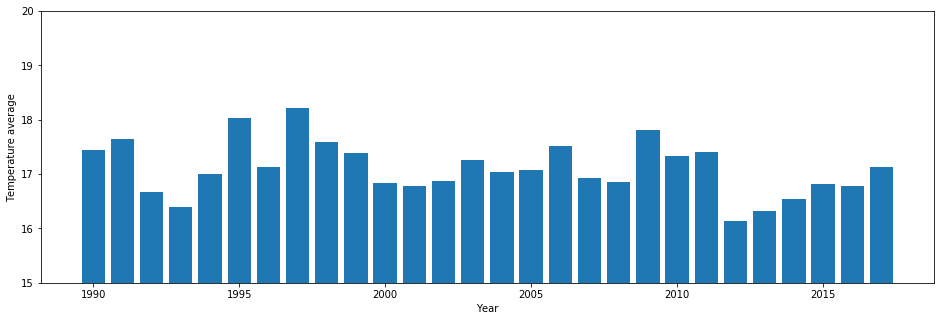

In [28]:
plt.figure(figsize=(16,5))
axes = plt.gca()
axes.set_ylim([15.0,20.0])
plt.bar(average_weather_conditions_peryear.index, average_weather_conditions_peryear['Temperature'])
plt.ylabel('Temperature average')
plt.xlabel('Year')
plt.show()

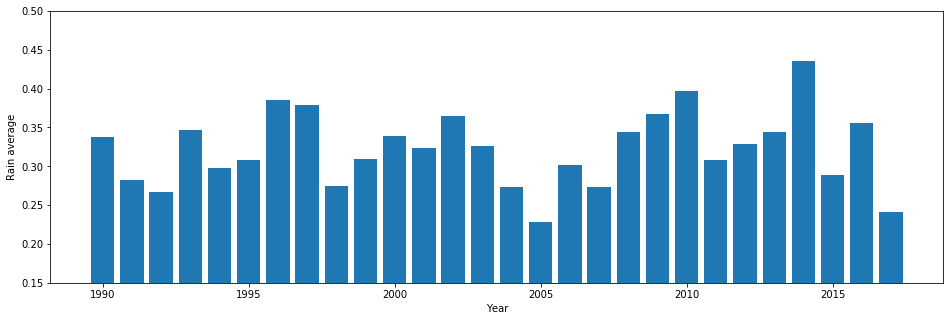

In [29]:
plt.figure(figsize=(16,5))
axes = plt.gca()
axes.set_ylim([0.15,0.5])
plt.bar(average_weather_conditions_peryear.index, average_weather_conditions_peryear['Rain'])
plt.ylabel('Rain average')
plt.xlabel('Year')
plt.show()

__Correlatie tabel:__

In onderstaande correlatie tabel is te hoe hoe weinig correlatie er te vinden is tussen gemiddelde weer per jaar en wijneigenschappen. Bij weer onderling is wel veel correlatie te vinden zoals tussen max windspeed en windspeed, min temperature en temperature. Dit zijn intuitief gezien geen rare resultaten.

Ook zien we wat interessantere inzichten zowel de correlatie van windspeed en temperature.

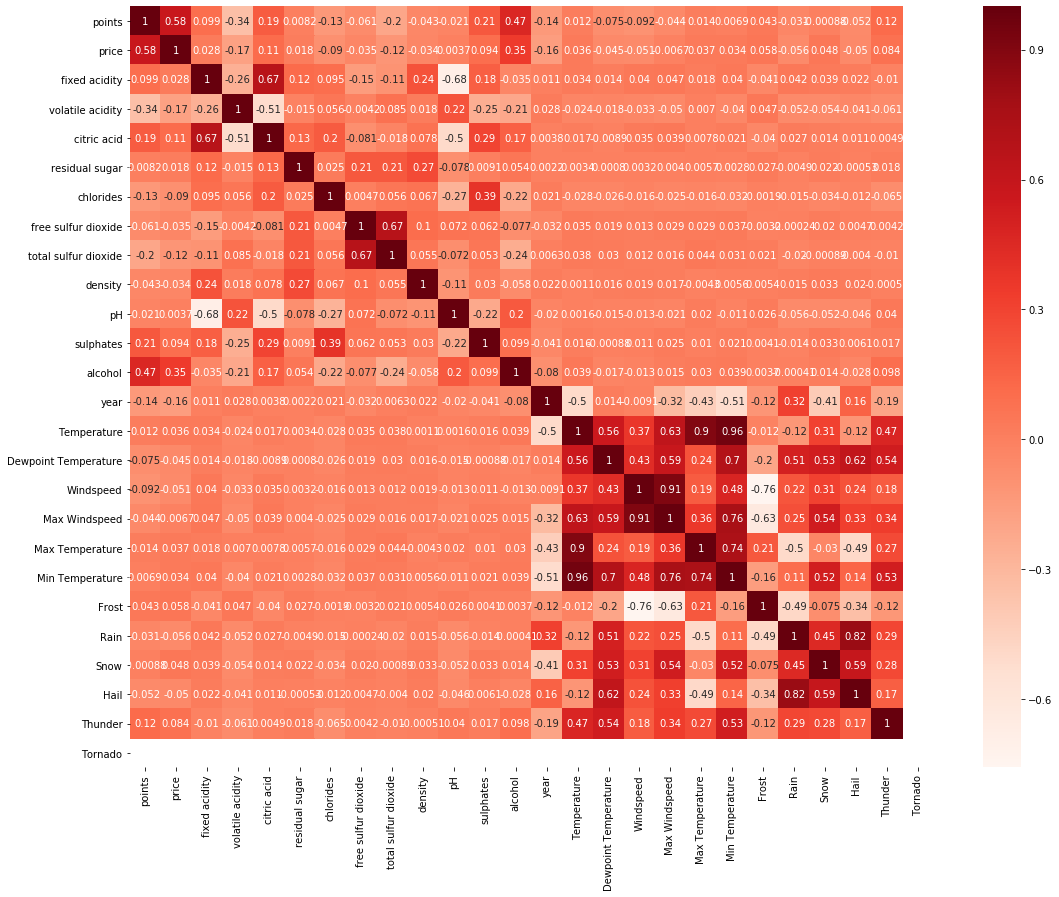

In [30]:
# Correlatie tabel voor dataset redwines
plt.figure(figsize=(18,14))
correlation_matrix = redwines_with_yeartemperatures.drop(['description','title','count'],axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

In [31]:
# dependent and independent columns
dependent = redwines_with_yeartemperatures['points']
independent = redwines_with_yeartemperatures[['Temperature','Rain','Max Temperature']]

# Test en train set
X_train, X_test, y_train, y_test = train_test_split(independent, dependent, random_state=0, test_size=0.1)

# Opzetten en trainen van model
model = LogisticRegression()
model.fit(X_train, y_train)

# Testen en uitrekenen nauwkeurigheid
#print(model.predict(X_test))
print(model.score(X_test,y_test))

0.1650485436893204


C:\Users\Freek\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Freek\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [32]:
#all_columns = ['Temperature','Max Temperature','Windspeed', 'Max Windspeed', "Dewpoint Temperature", "Frost", "Rain", "Snow", "Thunder","Tornado","Hail"]
all_columns = ['Temperature','Max Temperature', "Frost", "Rain"]
combs = []
all_combs_and_score = {}

for i in range(1, len(all_columns)+1):
    els = [list(x) for x in itertools.combinations(all_columns, i)]
    combs.extend(els)

for i in combs:
    
    for h in [0.1,0.2,0.3]:

        dependent = redwines_with_yeartemperatures['Max Windspeed']
        independent = redwines_with_yeartemperatures[i]

        # Test en train set
        X_train, X_test, y_train, y_test = train_test_split(independent, dependent, random_state=0, test_size=h)

        # Opzetten en trainen van model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Testen en uitrekenen nauwkeurigheid
        all_combs_and_score[model.score(X_test,y_test)] = str(i)+" met test size: " + str(h)

print(round(max(all_combs_and_score) * 100, 2),all_combs_and_score[max(all_combs_and_score)])

# LinearRegression
# LogisticRegression
# DecisionTreeClassifier

87.07 ['Temperature', 'Max Temperature', 'Frost', 'Rain'] met test size: 0.1


Er is zeer weinig correlatie te vinden tussen de 2 datasets. Het was enigzins te verwachten, omdat we niet op het weer per regio ingespeeld hebben maar het gemiddelde weer van Lissabon hebben genomen. Elke regio of gebied heeft immers zijn eigen weer, plant en oogst seizoenen. Als er meer data beschikbaar was geweest, en de data foutloos en accuraat was geweest (kolom province bevat niet alleen provincies) waren er mogelijk betere inzichten uit gekomen. De enige grote correlaties die gevonden zijn, zijn correlaties tussen de twee datasets onderling.

# 3. Onderzoeksvraag 3
Kan je op basis van score en prijs achterhalen in welke regio de wijn zijn oorsprong heeft.

Voor deze onderzoeksvraag is de data onderzocht per maand. Om deze vraag te beantwoorden, kijk ik eerst naar correlaties tussen de data van de maanden. Deze zijn gepresenteerd hieronder in een heatmap.

In [33]:
# Het omzetten van alle data gegroepeert op regio
redwines_interactive = redwines
redwines['count'] = 1
avg_per_regio = redwines.groupby('province').sum() 
avg_per_regio.loc[:, "points":"sulphates"] = avg_per_regio.loc[:, "points":"sulphates"].div(avg_per_regio['count'], axis=0)
avg_per_regio['province'] = avg_per_regio.index

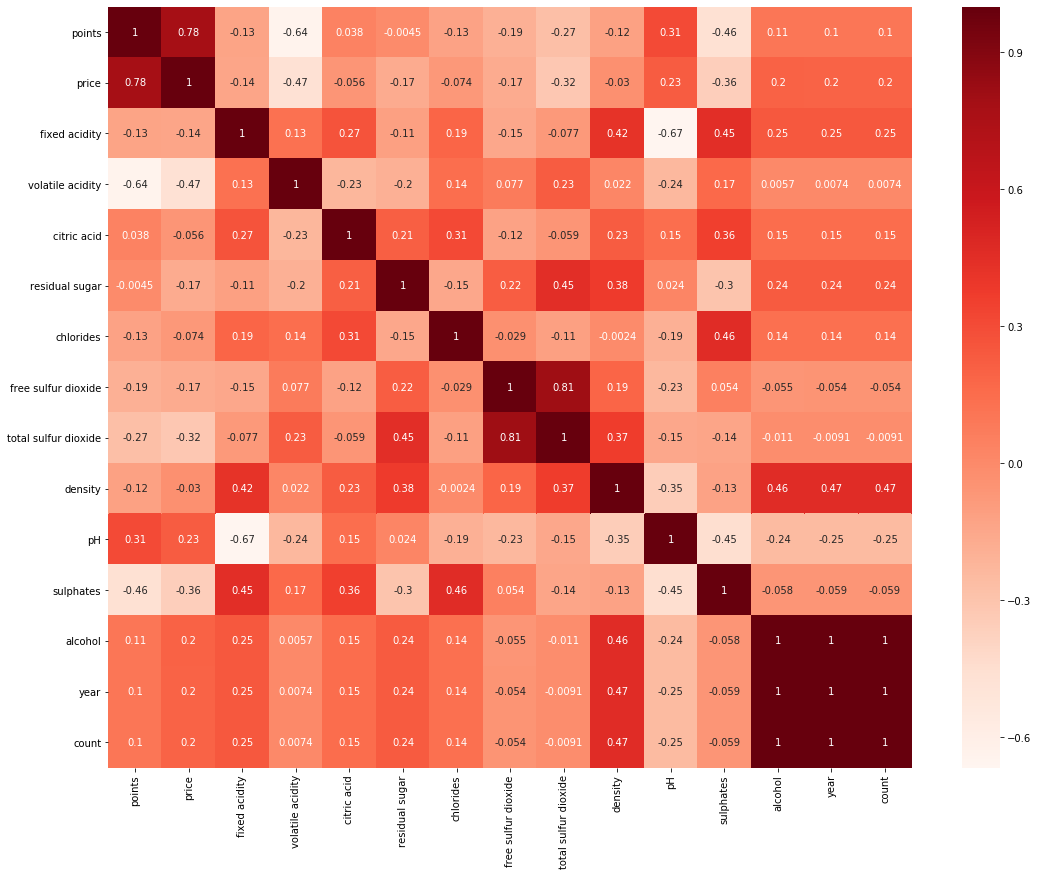

In [34]:
# Correlatieschema van alle gemiddeldes van alle maanden
plt.figure(figsize=(18,14))
correlation = avg_per_province.corr()
sns.heatmap(correlation, annot=True, cmap=plt.cm.Reds)

Tussen price en points zit een aardige correlatie. Wat betekent dat per regio de verhouding van punten gegeven door wijnproevers en de prijs aardig hoog ligt. Ook is de total sulfur dioxide ten opzichte van de sulfur vrije dioxide een aardige correlatie te vinden, een substantie welke een conserverende werking heeft. Voor nu ga ik mij focussen op de prijs en punten.

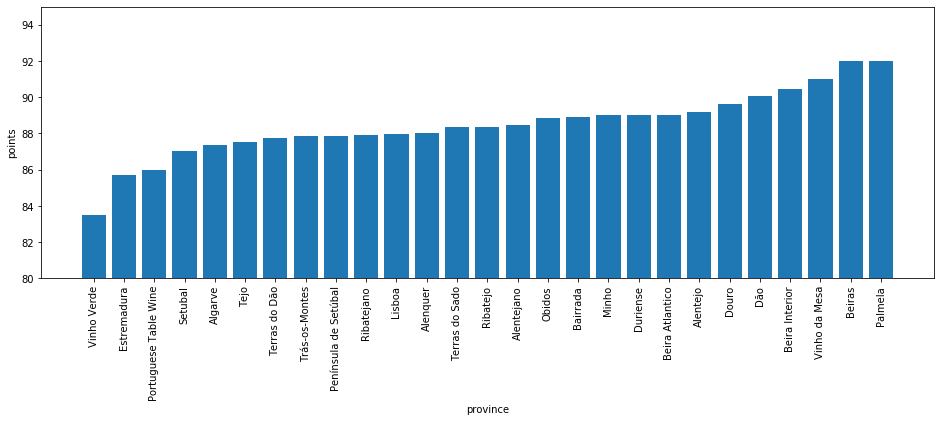

In [35]:
# Gemiddelde punten per regio
avg_points_sorted = avg_per_regio.sort_values(by=['points'])
plt.figure(figsize=(16,5))
plt.xticks(np.arange(27),(avg_points_sorted.index), rotation='vertical')
plt.ylim(80, 95)
plt.bar(avg_points_sorted['province'], avg_points_sorted['points'])
plt.xlabel('province')
plt.ylabel('points')
plt.show()

het gemiddelde aantal punten per regio liggen niet ver van elkaar af. Op basis van alleen punten zullen we dus niet kunnen concluderen welke regio de wijn vandaan komt.

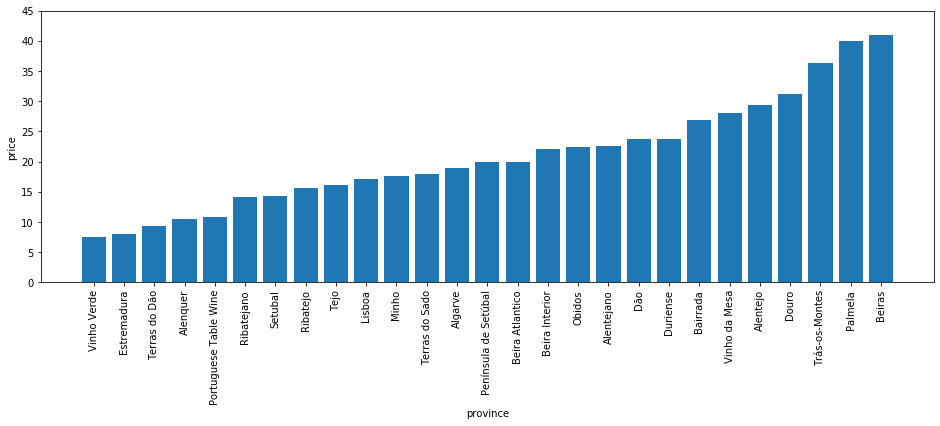

In [36]:
# Gemiddelde prijs per regio
avg_points_sorted = avg_per_regio.sort_values(by=['price'])
plt.figure(figsize=(16,5))
plt.xticks(np.arange(27),(avg_points_sorted.index), rotation='vertical')
plt.ylim(0, 45)
plt.bar(avg_points_sorted['province'], avg_points_sorted['price'])
plt.xlabel('regio')
plt.ylabel('price')
plt.show()

Uit de grafiek blijkt dat er best veel verschil zit tussen de gemiddelde prijs per regio. Op basis van deze informatie ik een model bouwen welke a.d.h.v. prijs en score welke probeert te achterhalen waar de wijn vandaan komt.

Op het moment ben ik benieuwd of er een duidelijke verhouding is tussen de prijs en punten per regio. Hiervoor brengt ik de vorige twee grafieken in kaart in een grafiek gecategoriseerd op regio.

In [37]:
# Namen geven aan een variabel
avg_price = avg_per_regio['price']
avg_points = avg_per_regio['points']
index = avg_per_regio.index

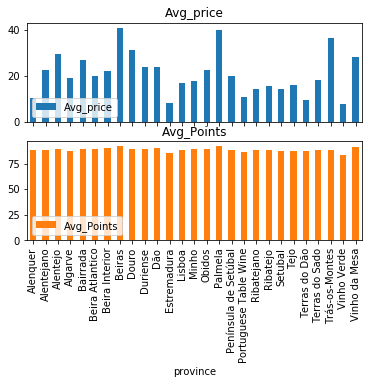

In [38]:
# Grafiek van gemiddelde prijs en punten per regio
df = pd.DataFrame({'Avg_price': avg_price,
                   'Avg_Points': avg_points}, index = index)
axes = df.plot.bar(rot=90, subplots=True)
axes[0].legend(loc=3)
axes[1].legend(loc=3)

Ondanks de hogere correlatie (0,78) bij de heatmap tussen score en prijs gecategoriseerd per regio, zie ik niet heel veel bijzonders aan de grafiek hierboven. Een ding wat je wel kan waarnemen dat enkele regio's met gemiddeld hogere wijnprijzen een iets hogere gemiddelde score heeft. Zo ook met gemiddelde lage wijnprijzen en scores. Echter blijft dat een kleine ontdekking.

Toch wil ik een model in elkaar zetten wat een voorspelling doet op basis van de hoofdvraag.

In [39]:
# Omzetten van regio in een integer
regio = {}
counter = 1
for item in avg_per_regio.index:
    regio[str(item)] = counter
    counter+=1
redwines['province'] = [regio[str(item)] for item in redwines['province']]

In [40]:
# Variables een naam geven
dependent = redwines['province']
independent = redwines[['points', 'price']]

# Een gemiddelde percentage als uitkomst nemen uit een x aantal testen
scores_in_percentage = []    
random_seed = 0
testen = 10
for i in range(testen):
    
    # Test en train set
    X_train, X_test, y_train, y_test = train_test_split(independent, dependent, random_state=random_seed, test_size=0.2)
    random_seed+=1
    
    # Training model
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    
    # Voeg de score toe aan lijst met gevonden scores
    scores_in_percentage.append(model.score(X_test, y_test))

# Rekent het gemiddelde uit van alle percentuele scores    
print(abs(((sum(scores_in_percentage)) / (len(scores_in_percentage))) * 100))

32.71844660194175


Wat op viel was dat er 3 modellen aardig goed presteerden. De DecisionTreeClassifier functie aan top met een nauwkeurigheid van 33,3%. De functie logisticRegression had een nauwkeurigheid van 32,0% en DecisionTreeRegressor kwam met 14,5% nauwkeurigheid. Alle test zijn gedaan op basis van 10 testen en daarvan het gemiddelde.

Uit deze informatie blijkt dat er aan de hand van deze dataset geen goede voorspelling kan worden gedaan waar de wijn vandaan komt.

Hierna keek ik of er op basis van andere elementen een goede voorspelling kan worden gedaan. Ik heb nog maals enkele test gedaan met meer parameters.

In [41]:
# Variables een naam geven
dependent = redwines['province']
independent = redwines[['total sulfur dioxide', 'price', 'points']]

# Een gemiddelde percentage als uitkomst nemen uit een x aantal testen
scores_in_percentage = []    
random_seed = 0
testen = 10
for i in range(testen):
    
    # Test en train set
    X_train, X_test, y_train, y_test = train_test_split(independent, dependent, random_state=random_seed, test_size=0.2)
    random_seed+=1
    
    # Training model
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    
    # Voeg de score toe aan lijst met gevonden scores
    scores_in_percentage.append(model.score(X_test, y_test))
    

# Rekent het gemiddelde uit van alle percentuele scores    
print(abs(((sum(scores_in_percentage)) / (len(scores_in_percentage))) * 100))

24.138349514563103


Met de functie DecisionTreeClassifier kan er tot 24,6% nauwkeurigheid worden voorspelt welke regio er bij de wijn hoort op basis van totaal zwaveldioxide, prijs en punten. Een vermindering tot de vorige.

Nu ben ik erg benieuwd of het model veel kan halen uit een stuk of 8 colums.

In [42]:
# Variables een naam geven
dependent = redwines['province']
independent = redwines[['points', 'price', 'fixed acidity', 'volatile acidity','residual sugar', 'total sulfur dioxide', 'chlorides']]

# Een gemiddelde percentage als uitkomst nemen uit een x aantal testen
scores_in_percentage = []    
random_seed = 0
testen = 10
for i in range(testen):
    
    # Test en train set
    X_train, X_test, y_train, y_test = train_test_split(independent, dependent, random_state=random_seed, test_size=0.2)
    random_seed+=1
    
    # Training model
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    
    # Voeg de score toe aan lijst met gevonden scores
    scores_in_percentage.append(model.score(X_test, y_test))

# Rekent het gemiddelde uit van alle percentuele scores    
print(abs(((sum(scores_in_percentage)) / (len(scores_in_percentage))) * 100))

23.106796116504853


Door vorige trainingssessies van modellen is er te zien dat de functie DecisionTreeclassifier vaak het beste uit de test komt. Door het combineren van de punten points, price, fixed acidity, volatile acidity, residual sugar, total sulfur dioxide, chlorides, kan er met 23,1% nauwkeurigheid gegokt worden waar de wijn vandaan komt.

Mijn conclusie is dat er op basis van punten en scores geen voorspelling kan worden gemaakt waar de wijn vandaan komt, dat komt voornamelijk doordat points voor de wijn te dicht op elkaar ligt. Ook wanneer er meer parameters worden meegenomen, is er weining te zeggen waar de wijn vandaan komt. De heatmap had wel gelijk in de zin dat prijs en score aardig goed bij elkaar passen.

# Hypothese toets

In [43]:
ph_sample = np.array([3.41, 3.51, 3.39, 3.11, 3.21, 3.50, 3.46, 3.37, 3.71]) # steekproef data

__Nul Hypothese (H0):__

_Er is geen significant verschil te vinden tussen de gemiddelde PH waardes van de steekproef en de populatie. Dat wil zeggen, als de z score aan de boven en onderkant binnen -1.960 en 1.960 (2,5% links en rechts, 95% in het midden) valt, is er geen significant verschil te vinden_

_Als de P waarde hoger is dan de alpha waarde, is er ook geen significant verschil._

__Alternatieve Hypothese (HA):__

_Er is wel een significant verschil tussen gemiddelde PH waardes van de steekproef en de populatie. Dat wil zeggen, als de z score aan de boven of onderkant buiten -1.960 en 1.960 (2,5% links en rechts, 95% in het midden) valt, is er wel een significant verschil te vinden_

_Als de P waarde lager is dan de alpha waarde, is er ook een significant verschil._

__Toetszijde(s):__

_Het gaat om tweezijdig (beide zijdes) toetsen, aangezien we een significant verschil zoeken, een verschil kan zowel aan de lage kant als aan de hoge kant zitten._

In [44]:
# Eerst de steekproef- en populatiestatistieken berekenen

# steekproefstatistieken
x_ = ph_sample.mean() # Gemiddelde van de steekproef
n = len(ph_sample) # Grootte steekproef
s = ph_sample.std()

# populatiestatistieken
population = len(redwines_with_yeartemperatures['pH'])
sigma = redwines_with_yeartemperatures['pH'].std() # Standaard deviatie van de populatie
mu = redwines_with_yeartemperatures['pH'].mean() # Gemiddlede van de populatie

# margin of error en standard error
alpha = 0.05 # 95% betrouwbaarheid
se = sigma / np.sqrt(n) # standard error using sigma of population, since its available

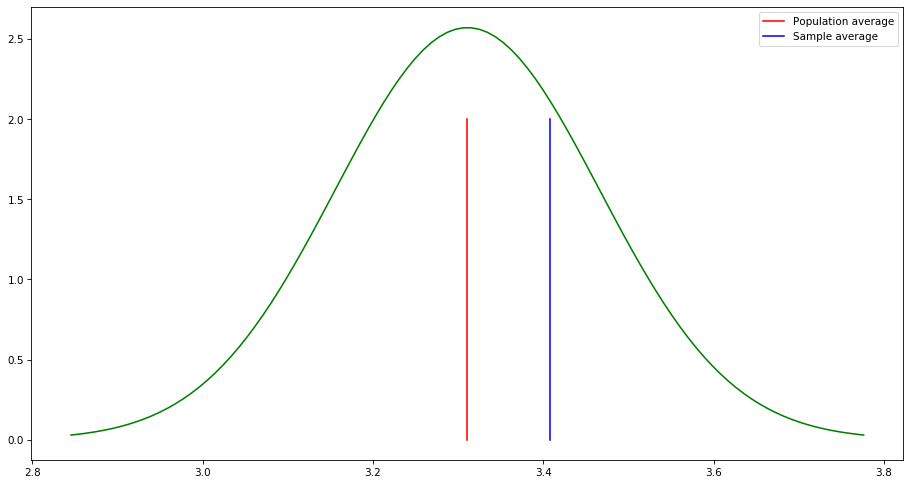

In [45]:
# plot de normaalverdeling met gemiddelde van populatie en gemiddelde van steekproef
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.figure(figsize=(15,8), dpi=75)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color='green')
plt.plot([mu,mu],[0,2],color='red', label='Population average') # gemiddelde populatie
plt.plot([x_,x_],[0,2],color='blue', label='Sample average') # gemiddelde steekproef
plt.legend()
plt.show()

In [46]:
print("Methode 1:\n")

sample_z_score = (x_ - mu) / se
sample_alpha = stats.norm.pdf(sample_z_score)

print("Steekproef:")
print("Z Score Steekproef:\n", sample_z_score)
print("P waarde steekproef:\n", sample_alpha)

population_z_score = stats.norm.ppf((1 - alpha / 2)) # 2 zijdig 0.975

print("\nPopulatie:")
print("Z Score middelste 95% populatie (2,5 links en rechts):\n", population_z_score)
print("Margin of error populatie:\n", alpha)

print("\nSteekproef kans is hoger dan alpha populatie, dus verwerp HA : ~0.06 > 0.05")

Methode 1:

Steekproef:
Z Score Steekproef:
 1.8743091579469984
P waarde steekproef:
 0.06887541797074803

Populatie:
Z Score middelste 95% populatie (2,5 links en rechts):
 1.959963984540054
Margin of error populatie:
 0.05

Steekproef kans is hoger dan alpha populatie, dus verwerp HA : ~0.06 > 0.05


In [47]:
print("Methode 2:\n")

z_score_left = ((x_ - mu) / se) * -1
z_score_right = (x_ - mu) / se
grens_ph_sample_left = z_score_left * se + x_
grens_ph_sample_right = z_score_right * se + x_

print("Steekproef:")
print("Z Score Steekproef links en rechts met SE "+str(se)+":\n", z_score_left, z_score_right)
print("Grens PH waarde links en rechts:\n", grens_ph_sample_left, grens_ph_sample_right)

z_score_left = stats.norm.ppf((alpha / 2)) # 2 zijdig 0.025
z_score_right = stats.norm.ppf((1 - alpha / 2)) # 2 zijdig 0.975
grens_ph_population_left = z_score_left * sigma + mu
grens_ph_population_right = z_score_right * sigma + mu

print("\nPopulatie:")
print("Z Score 2,5% links en 97,5% rechts met SD "+str(sigma)+":\n", z_score_left, z_score_right)
print("Grens PH waarde links en rechts:\n", grens_ph_population_left, grens_ph_population_right)

print("\n\nDe alternatieve hypothese (HA) vervalt omdat er is geen significant verschil tussen de gemiddelde PH waarde "
      "van de steekproef en de populatie is. Zowel de Z scores als de bijbehorende PH waardes vallen binnen de 95%"
      " van de populatie. Dat de steekproef data (sample) binnen de 95% van de gehele populatie valt is uitgebeeld in"
      " onderstaande grafiek. Alternatieve Hypothese (HA) vervalt.")

Methode 2:

Steekproef:
Z Score Steekproef links en rechts met SE 0.05170376793393496:
 -1.8743091579469984 1.8743091579469984
Grens PH waarde links en rechts:
 3.3108689320388374 3.5046866235167187

Populatie:
Z Score 2,5% links en 97,5% rechts met SD 0.15511130380180488:
 -1.9599639845400545 1.959963984540054
Grens PH waarde links en rechts:
 3.006856362992249 3.6148815010854256


De alternatieve hypothese (HA) vervalt omdat er is geen significant verschil tussen de gemiddelde PH waarde van de steekproef en de populatie is. Zowel de Z scores als de bijbehorende PH waardes vallen binnen de 95% van de populatie. Dat de steekproef data (sample) binnen de 95% van de gehele populatie valt is uitgebeeld in onderstaande grafiek. Alternatieve Hypothese (HA) vervalt.


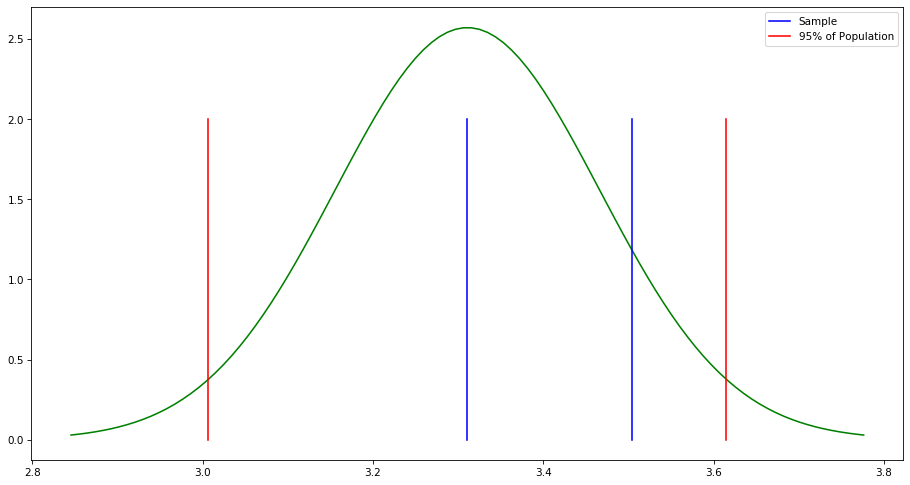

In [48]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.figure(figsize=(15,8), dpi=75)
plt.plot(x, stats.norm.pdf(x, mu, sigma),color='green')
plt.plot([grens_ph_sample_left,grens_ph_sample_left],[0,2],color='blue', label='Sample')
plt.plot([grens_ph_sample_right,grens_ph_sample_right],[0,2],color='blue')
plt.plot([grens_ph_population_left,grens_ph_population_left],[0,2],color='red', label='95% of Population')
plt.plot([grens_ph_population_right,grens_ph_population_right],[0,2],color='red')
plt.legend()
plt.show()

## Een interactieve visualisatie

In [49]:
# Omzetten van integer naar regio
regio = {}
counter = 1
for item in avg_per_regio.index:
    regio[str(item)] = counter
    counter+=1
keys = list(regio.keys())
values = list(regio.values())
redwines['province'] = [keys[values.index(item)] for item in redwines['province']]

NameError: name 'avg_per_regio' is not defined